<a href="https://colab.research.google.com/github/nishuchy/AI-works/blob/main/Predicting_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup and Data Loading

In [26]:
# @title 1. Setup and Data Loading
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# For preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


In [27]:
# For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron (Neural Network)

# For evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay

# --- Load the Dataset ---
# You might need to upload the 'heart_disease_uci.csv' file to your Colab environment
# or mount Google Drive if it's stored there.

# Option 1: Upload directly to Colab (will be deleted after session)
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv('heart_disease_uci.csv')

# Option 2: Assuming the file is directly accessible (e.g., from Kaggle kernel or uploaded via files.upload())
# Make sure the file name matches
try:
    df = pd.read_csv('/content/heart_disease_uci.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'heart_disease_uci.csv' not found. Please upload the file or check the path.")
    # As a fallback for demonstration, you might load a similar dataset via URL if available
    # For now, we'll stop if file not found.
    exit() # Exit if dataset isn't loaded for the rest of the tutorial

# Display basic info
print("\n--- Dataset Head ---")
print(df.head())
print("\n--- Dataset Info ---")
df.info()

Dataset loaded successfully!

--- Dataset Head ---
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3            

2. Exploratory Data Analysis (EDA)


--- Missing Values ---
id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

--- Descriptive Statistics ---
          count        mean         std   min     25%    50%     75%    max
id        920.0  460.500000  265.725422   1.0  230.75  460.5  690.25  920.0
age       920.0   53.510870    9.424685  28.0   47.00   54.0   60.00   77.0
trestbps  861.0  132.132404   19.066070   0.0  120.00  130.0  140.00  200.0
chol      890.0  199.130337  110.780810   0.0  175.00  223.0  268.00  603.0
thalch    865.0  137.545665   25.926276  60.0  120.00  140.0  157.00  202.0
oldpeak   858.0    0.878788    1.091226  -2.6    0.00    0.5    1.50    6.2
ca        309.0    0.676375    0.935653   0.0    0.00    0.0    1.00    3.0
num       920.0    0.995652    1.142693   0.0    0.00    1.0    2.0

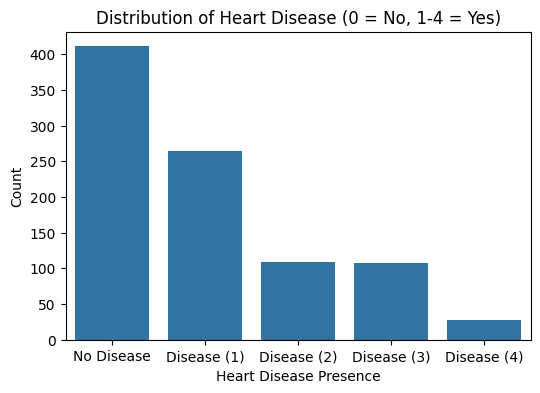


--- New Binary Target Distribution ---
target
1    509
0    411
Name: count, dtype: int64


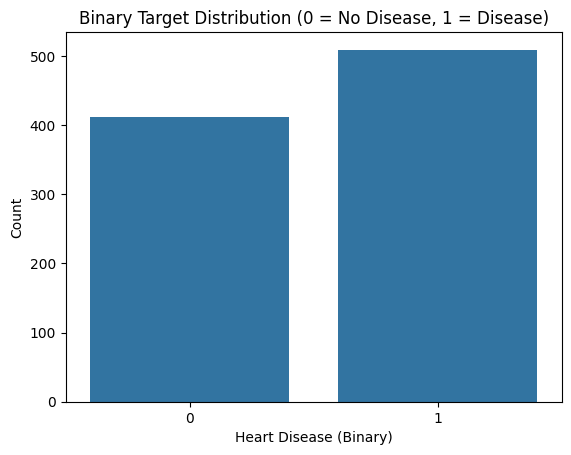

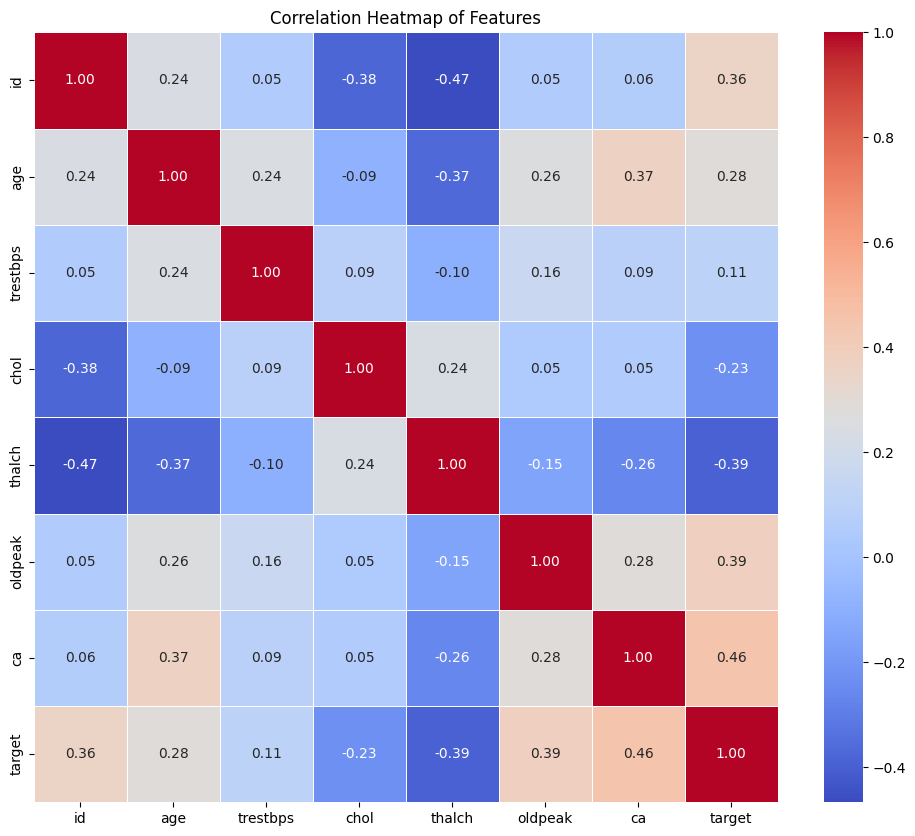

In [28]:
# @title 2. Exploratory Data Analysis (EDA)

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Descriptive Statistics ---")
print(df.describe().T)

# Check unique values for categorical features and target
print("\n--- Unique values for 'ca' and 'thal' (and target 'num') ---")
print(df['ca'].value_counts(dropna=False)) # 'ca' might have '?'
print(df['thal'].value_counts(dropna=False)) # 'thal' might have '?'
print(df['num'].value_counts()) # Target variable

# Convert '?' to NaN for easier handling
df.replace('?', np.nan, inplace=True)

# Convert relevant columns to numeric (they might have been loaded as object due to '?')
df['ca'] = pd.to_numeric(df['ca'])
# df['thal'] = pd.to_numeric(df['thal']) # Removed this line

# Re-check unique values and info after conversion
print("\n--- Unique values after '?' to NaN conversion and numeric casting ---")
print(df['ca'].value_counts(dropna=False))
print(df['thal'].value_counts(dropna=False)) # 'thal' is still object type
df.info() # Check dtypes again

# Distribution of Target Variable
plt.figure(figsize=(6, 4))
sns.countplot(x='num', data=df)
plt.title('Distribution of Heart Disease (0 = No, 1-4 = Yes)')
plt.xlabel('Heart Disease Presence')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['No Disease', 'Disease (1)', 'Disease (2)', 'Disease (3)', 'Disease (4)'])
plt.show()

# The target variable 'num' has values 0, 1, 2, 3, 4.
# According to UCI documentation, 0 = no disease, 1-4 = presence of disease.
# We will convert this into a binary classification problem: 0 (No Disease) vs 1 (Disease).
df['target'] = df['num'].apply(lambda x: 0 if x == 0 else 1) # Create new binary target
print("\n--- New Binary Target Distribution ---")
print(df['target'].value_counts())
sns.countplot(x='target', data=df)
plt.title('Binary Target Distribution (0 = No Disease, 1 = Disease)')
plt.xlabel('Heart Disease (Binary)')
plt.ylabel('Count')
plt.show()

# Drop the original 'num' column as we have created 'target'
df

# Correlation Heatmap
plt.figure(figsize=(12, 10))
# Exclude non-numeric columns before calculating correlation
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.drop(columns=['num']).corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Features')
plt.show()

# Pairplot for selected features vs. target (sampling might be needed for large datasets)
# sns.pairplot(df[['age', 'chol', 'thalach', 'target']], hue='target', plot_kws={'alpha': 0.6})
# plt.suptitle('Pairplot of Key Features by Target', y=1.02)
# plt.show()

3. Data Cleaning, Preprocessing, and Feature Engineering

In [31]:
# Define features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

# Identify numerical and categorical features
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
# categorical_cols = X.select_dtypes(include='object').columns.tolist() # 'sex', 'cp', 'fbs',
# 'restecg', 'exang', 'slope', 'thal' (after cleaning)

# Re-checking categorical columns after the initial `?` handling (as 'thal' and 'ca' are now
# numeric)
# Best practice is to define them based on domain knowledge or explicit checking after initial
# cleaning.
# Let's manually define based on the dataset nature and common practice:
# Added 'thal' to categorical_cols
categorical_cols = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'] # 'thal' and 'ca' are
# often treated as categorical-like but are numeric encoded in this dataset sometimes

# Ensure 'thal' and 'ca' are treated appropriately. Given they were numeric after '?' to NaN,
# they are numerical here.
# If they were truly categories (e.g., 'normal', 'fixed defect', 'reversible defect'), they'd
# be in categorical_cols.
# For this dataset, they are often integer encoded, so treating them as numerical is fine for
# now, or explicitly encoding.
# Let's assume for simplicity they are numerical *after* cleaning and conversion for this step.

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute missing numerical values with mean
    ('scaler', StandardScaler())                 # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values with most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-hot encode categorical features
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Keep other columns untouched (if any, though none here)
)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y) # Stratify helps maintain class distribution

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Apply preprocessing to training and testing data
# We will integrate this into a pipeline for each model below for cleaner code

Numerical columns: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num']
Categorical columns: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

X_train shape: (736, 16)
X_test shape: (184, 16)
y_train shape: (736,)
y_test shape: (184,)



**4. Model Training and Evaluation **


--- Training Logistic Regression ---
Accuracy: 1.0000

Confusion Matrix:
 [[ 82   0]
 [  0 102]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00       102

    accuracy                           1.00       184
   macro avg       1.00      1.00      1.00       184
weighted avg       1.00      1.00      1.00       184



<Figure size 600x500 with 0 Axes>

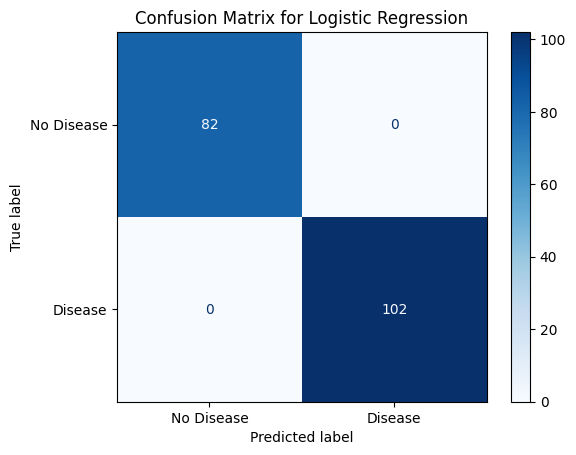

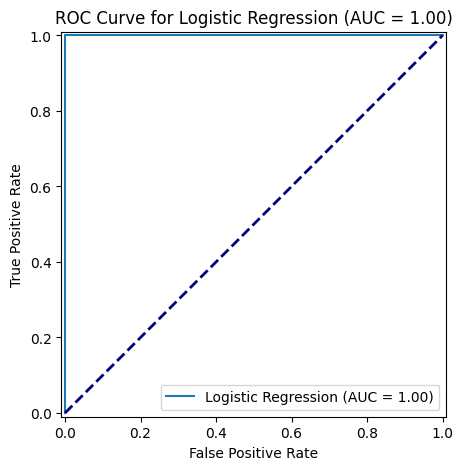


--- Training K-Nearest Neighbors ---
Accuracy: 0.9076

Confusion Matrix:
 [[71 11]
 [ 6 96]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89        82
           1       0.90      0.94      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.90      0.91       184
weighted avg       0.91      0.91      0.91       184



<Figure size 600x500 with 0 Axes>

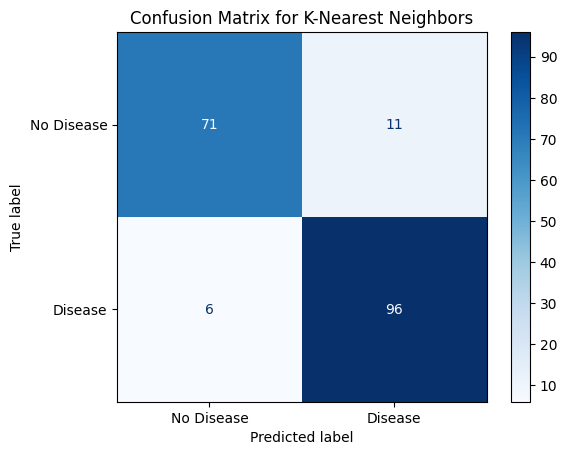

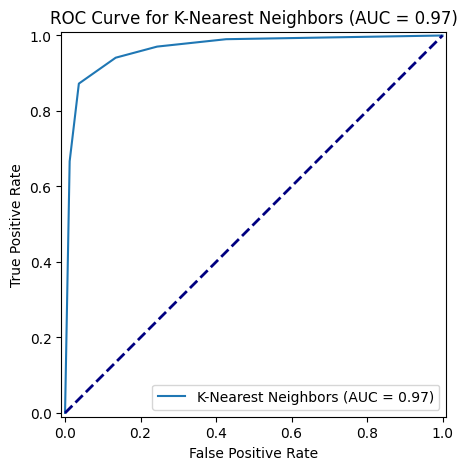


--- Training Support Vector Machine ---
Accuracy: 0.9891

Confusion Matrix:
 [[ 80   2]
 [  0 102]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        82
           1       0.98      1.00      0.99       102

    accuracy                           0.99       184
   macro avg       0.99      0.99      0.99       184
weighted avg       0.99      0.99      0.99       184



<Figure size 600x500 with 0 Axes>

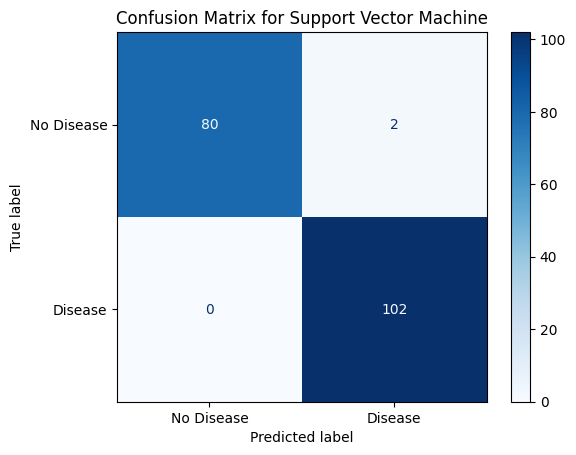

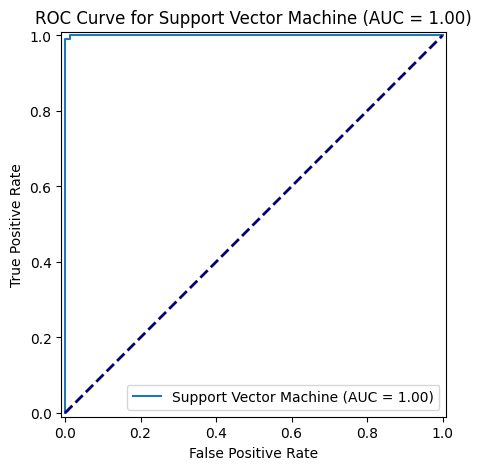


--- Training Decision Tree ---
Accuracy: 1.0000

Confusion Matrix:
 [[ 82   0]
 [  0 102]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00       102

    accuracy                           1.00       184
   macro avg       1.00      1.00      1.00       184
weighted avg       1.00      1.00      1.00       184



<Figure size 600x500 with 0 Axes>

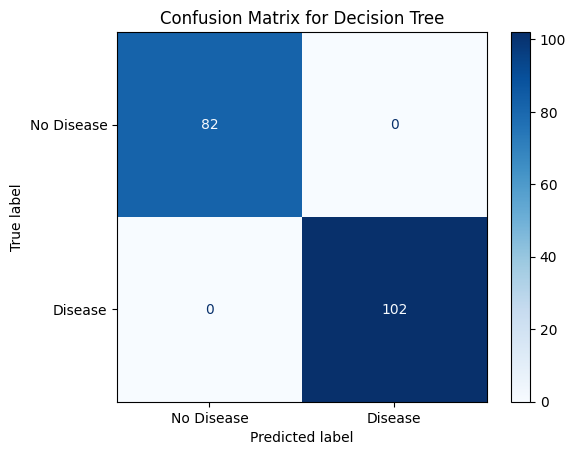

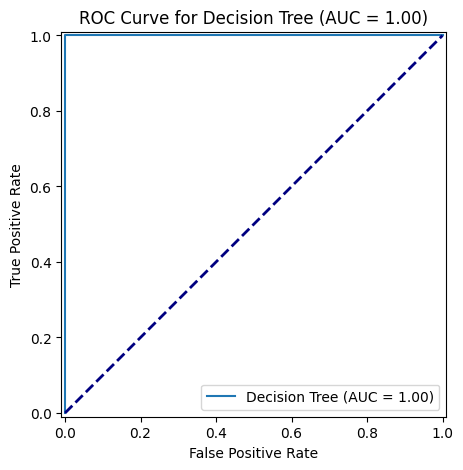


--- Training Random Forest ---
Accuracy: 1.0000

Confusion Matrix:
 [[ 82   0]
 [  0 102]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00       102

    accuracy                           1.00       184
   macro avg       1.00      1.00      1.00       184
weighted avg       1.00      1.00      1.00       184



<Figure size 600x500 with 0 Axes>

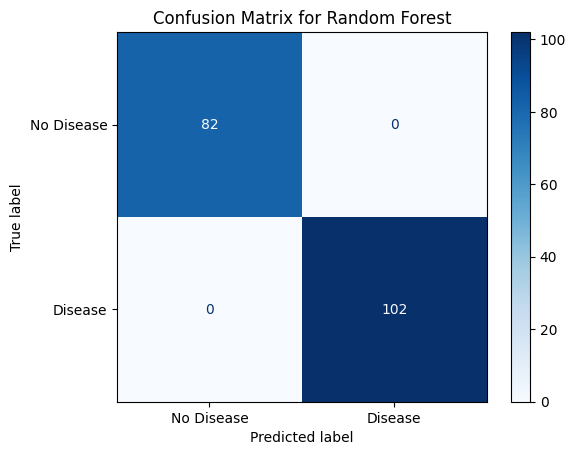

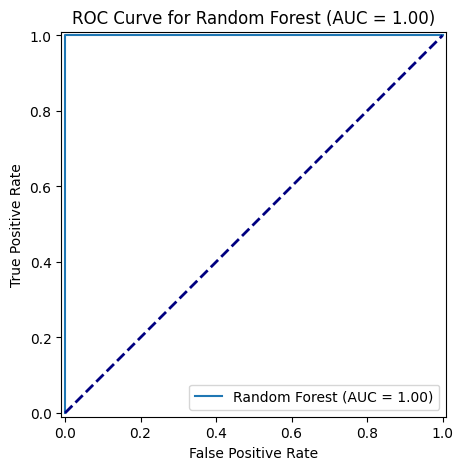


--- Training Gradient Boosting ---
Accuracy: 1.0000

Confusion Matrix:
 [[ 82   0]
 [  0 102]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00       102

    accuracy                           1.00       184
   macro avg       1.00      1.00      1.00       184
weighted avg       1.00      1.00      1.00       184



<Figure size 600x500 with 0 Axes>

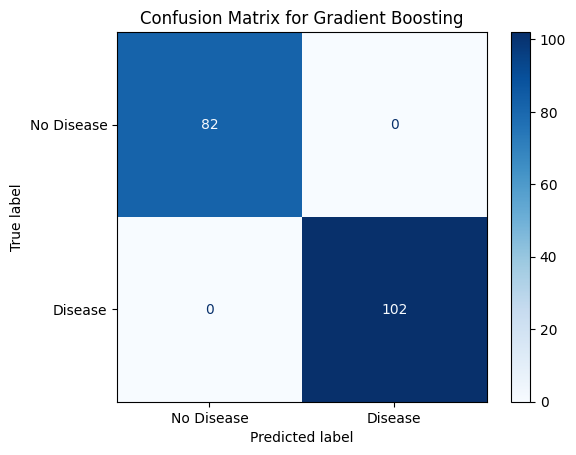

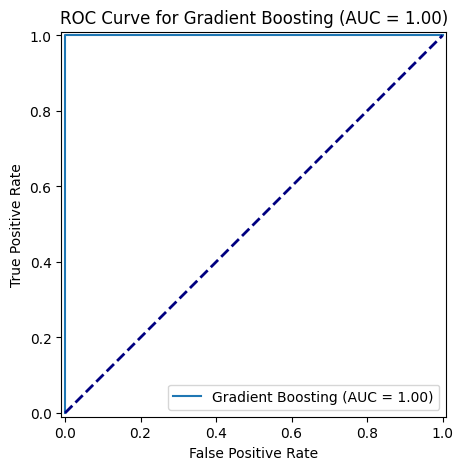


--- Training Neural Network (MLP) ---
Accuracy: 1.0000

Confusion Matrix:
 [[ 82   0]
 [  0 102]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00       102

    accuracy                           1.00       184
   macro avg       1.00      1.00      1.00       184
weighted avg       1.00      1.00      1.00       184



<Figure size 600x500 with 0 Axes>

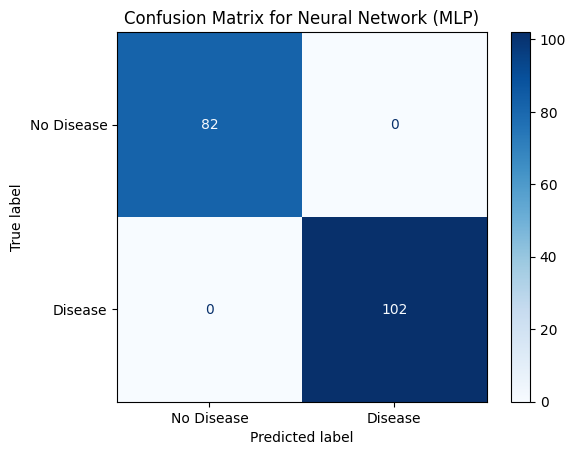

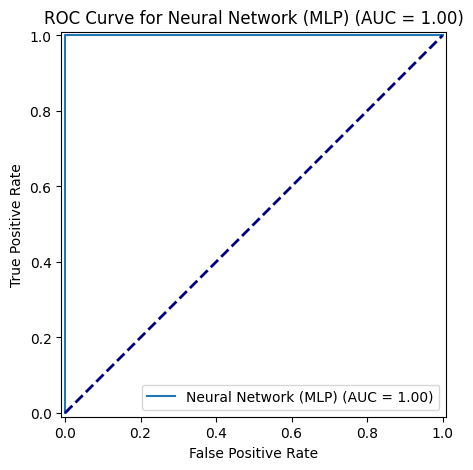


--- All models trained and evaluated. ---


In [32]:
# @title 4. Model Training and Evaluation

# Define a dictionary of models to train
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(probability=True, random_state=42), # probability=True for ROC curve
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Neural Network (MLP)': MLPClassifier(random_state=42, max_iter=1000) # Increased max_iter for convergence
}

results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")

    # Create a full pipeline (preprocessing + model)
    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', model)])

    # Train the model
    full_pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = full_pipeline.predict(X_test)
    y_proba = full_pipeline.predict_proba(X_test)[:, 1] # Probability of positive class

    # --- Performance Metrics ---
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)

    # Store results
    results[name] = {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'model_pipeline': full_pipeline # Store the trained pipeline
    }

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Disease',
    'Disease'])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # Plot ROC Curve
    plt.figure(figsize=(6, 5))
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name).plot(ax=plt.gca())
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(f'ROC Curve for {name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

print("\n--- All models trained and evaluated. ---")

5. Summary of Algorithm Performance and Decision Making

In [35]:
# @title 5. Summary of Algorithm Performance and Decision Making

print("\n--- Summary of Model Performance ---")
for name, res in results.items():
    print(f"\n{name}:")
    print(f"  Accuracy: {res['accuracy']:.4f}")
    print(f"  Confusion Matrix:\n{res['confusion_matrix']}")
    print(f"  Classification Report:\n{res['classification_report']}")

# --- Decision Making ---
# Compare accuracies
best_model_name = max(results, key=lambda name: results[name]['accuracy'])
print(f"\nBest performing model based on Accuracy: {best_model_name} with Accuracy ={results[best_model_name]['accuracy']:.4f}")

# Further analysis: Look at Recall (Sensitivity) for the positive class (Disease)
# A high recall means fewer actual positive cases are missed (fewer False Negatives).
# This is crucial in medical diagnosis where missing a disease can have severe consequences.
print("\n--- Recall for 'Disease' Class (Positive Class, Label 1) ---")
recall_scores = {}
for name, res in results.items():
    report_dict = classification_report(y_test, res['model_pipeline'].predict(X_test),
output_dict=True)
    recall_disease = report_dict['1']['recall']
    recall_scores[name] = recall_disease
    print(f"  {name}: Recall = {recall_disease:.4f}")

best_recall_model_name = max(recall_scores, key=recall_scores.get)
print(f"Best performing model based on Recall (for Disease): {best_recall_model_name} with Recall = {recall_scores[best_recall_model_name]:.4f}")

# Consider Precision as well: High precision means fewer healthy people are incorrectly diagnosed with the disease (fewer False Positives).
# This is important to avoid unnecessary stress and invasive procedures.
print("\n--- Precision for 'Disease' Class (Positive Class, Label 1) ---")
precision_scores = {}
for name, res in results.items():
    report_dict = classification_report(y_test, res['model_pipeline'].predict(X_test),
output_dict=True)
    precision_disease = report_dict['1']['precision']
    precision_scores[name] = precision_disease
    print(f"  {name}: Precision = {precision_disease:.4f}")

best_precision_model_name = max(precision_scores, key=precision_scores.get)

print(f"Best performing model based on Precision (for Disease): {best_precision_model_name} with Precision = {precision_scores[best_precision_model_name]:.4f}")

print("\n--- Overall Decision Making ---")
print("Choosing the 'best' model depends on the specific priorities:")
print("- If minimizing missed disease cases (False Negatives) is paramount, prioritize **Recall**.")
print("- If minimizing false alarms (False Positives) is paramount, prioritize **Precision**.")
print("- **F1-score** provides a balance between Precision and Recall.")
print("- **ROC AUC** gives an overall measure of the model's ability to distinguish between classes.")

print("\nIn a medical context like heart disease prediction, a high Recall (sensitivity) is often critical to ensure that as many actual cases of heart disease are identified as possible, even if it means a slightly lower precision (more false alarms). However, the balance always depends on the downstream impact of false positives vs. false negatives. Random Forest or Gradient Boosting often provide a good balance and strong predictive power.")


--- Summary of Model Performance ---

Logistic Regression:
  Accuracy: 1.0000
  Confusion Matrix:
[[ 82   0]
 [  0 102]]
  Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00       102

    accuracy                           1.00       184
   macro avg       1.00      1.00      1.00       184
weighted avg       1.00      1.00      1.00       184


K-Nearest Neighbors:
  Accuracy: 0.9076
  Confusion Matrix:
[[71 11]
 [ 6 96]]
  Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        82
           1       0.90      0.94      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.90      0.91       184
weighted avg       0.91      0.91      0.91       184


Support Vector Machine:
  Accuracy: 0.9891
  Confusion Matrix:
[[ 80   2]
 [  0 102]]
  Class

6. Making Predictions on New Data

In [43]:
# @title 6. Making Predictions on New Data

# Let's say we pick the Random Forest model for demonstration
# You can change this to any model from the 'results' dictionary
chosen_model_name = best_recall_model_name # Or best_model_name, etc.
chosen_pipeline = results[chosen_model_name]['model_pipeline']
print(f"\n--- Making Predictions using the Chosen Model: {chosen_model_name} ---")

# Example of new patient data (hypothetical, ensure features match dataset order/type)
# Features: age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal
new_patient_data = pd.DataFrame([{
    'age': 55,
    'sex': 'Male',  # Use string values for categorical features
    'dataset': 'Cleveland', # Include dataset column with a representative value
    'cp': 'typical angina',   # Use string values for categorical features
    'trestbps': 130.0, # Resting blood pressure
    'chol': 240.0, # Serum cholestoral in mg/dl
    'fbs': False,  # Fasting blood sugar > 120 mg/dl (True/False)
    'restecg': 'normal', # Resting electrocardiographic results (string values)
    'thalch': 150.0, # Maximum heart rate achieved
    'exang': False,  # Exercise induced angina (True/False)
    'oldpeak': 1.0, # ST depression induced by exercise relative to rest
    'slope': 'downsloping',  # The slope of the peak exercise ST segment (string values)
    'ca': 0.0,   # Number of major vessels (0-3) colored by flourosopy (numeric)
    'thal': 'normal',    # Thalassemia (string values)
    'id': 921, # Include id column with a placeholder value
     'num': 0 # Do NOT include 'num' as it was dropped and replaced by 'target'
}])

# Ensure the new_patient_data DataFrame has the same columns and order as X_train
# (though preprocessor handles order as long as names match)
print("\nNew Patient Data:")
print(new_patient_data)

# Predict the probability of heart disease
prediction_proba = chosen_pipeline.predict_proba(new_patient_data)[0]
# Predict the class (0 or 1)

prediction_class = chosen_pipeline.predict(new_patient_data)[0]
print(f"\nPrediction for new patient using {chosen_model_name}:")
print(f"  Probability of No Heart Disease: {prediction_proba[0]:.4f}")
print(f"  Probability of Heart Disease: {prediction_proba[1]:.4f}")
if prediction_class == 1:
  print(f"  **Predicted Class: HEART DISEASE**")
else:
  print(f"  **Predicted Class: NO HEART DISEASE**")
# Decision Making based on Prediction
if prediction_class == 1 and prediction_proba[1] > 0.6: # Example threshold
  print("\nDecision: This patient has a high predicted probability of heart disease. Further   medical evaluation is strongly recommended.")
elif prediction_class == 1:
  print("\nDecision: This patient is predicted to have heart disease. Consider further diagnostics or monitoring.")
else:
  print("\nDecision: This patient is predicted not to have heart disease based on the provided data. Continue routine check-ups.")


--- Making Predictions using the Chosen Model: Logistic Regression ---

New Patient Data:
   age   sex    dataset              cp  trestbps   chol    fbs restecg  \
0   55  Male  Cleveland  typical angina     130.0  240.0  False  normal   

   thalch  exang  oldpeak        slope   ca    thal   id  num  
0   150.0  False      1.0  downsloping  0.0  normal  921    0  

Prediction for new patient using Logistic Regression:
  Probability of No Heart Disease: 0.9479
  Probability of Heart Disease: 0.0521
  **Predicted Class: NO HEART DISEASE**

Decision: This patient is predicted not to have heart disease based on the provided data. Continue routine check-ups.
